In [248]:
%matplotlib inline

from __future__ import division
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pdb
from abc import ABCMeta, abstractmethod,abstractproperty
from scipy.optimize import curve_fit

In [230]:
from types import FunctionType 

class AbstractSystemModel(object):
    __metaclass__ = ABCMeta
    
    
        
    
    @abstractmethod
    def evaluate_model(self,t,scaling_parameters,system_parameters):
        """
        Evaluate the model for a given set of times, scaling parameters, and system parameters
        
        Args:
            t (np.array): array of times of length N
            scaling_parameters (np.array): An array of length kxm where k is the number of different 
                                        sets of scaling parameters to be evaluated, and each column of
                                        length m are the scaling parameters. 
                                        
            system_parameters (np.array): An array of length kxn where k is the number of different 
                                        sets of system parameters to be evaluated, and each column of
                                        length n are the system parameters. 
                                        
        Returns:
            np.array : An array of evaluate models for each time point of dimensions Nxl where l depends
                        on if there are multiple outputs for a model (ie. two channels on an NMR spectrometer)
                    
        """
        pass

    
    


In [231]:
class OrthonormalizableSystemModel(AbstractSystemModel):
    
    #@abstractmethod
    #def orthonormalize(self,data):
    #    """
    #   return orthonormalized model
    #   """
        
        
        pass

In [232]:
class AbstractNoiseModel(object):
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def add_noise(self,data):
        pass

class GaussianNoiseModel(AbstractNoiseModel):
    
    def __init__(self,sigma,offset):
        self.sigma = sigma
        self.offset = offset
    
    def add_noise(self,data):
        return data+np.random.normal(self.offset,self.sigma,data.shape)



In [233]:
from numpy.core.umath_tests import inner1d

class GenericConvexCombinationModel(OrthonormalizableSystemModel):
    
    def __init__(self,scaling_parameters,system_parameters,model_functions,noise_rms = None,parameter_dtype = np.float32):
        """
        Initialize model of the form  :math:`f(t)= \sum \limits_i^N B_i*G_i(t,{\omega})`
        where :math:`{B}` are the scaling parameters, :math:`{\omega}` are the model parameters,
        and  :math:`{G(t,{\omega})}` are the model functions (python functions).
        
        Args: 
            scaling_parameters (np.ndarray or int): A list of named strings for scaling parameters, or an integer
                                              that specifies the number of scaling parameters.
            system_parameters (np.ndarray or int): A list of named strings for system parameters, or an integer
                                              that specifies the number of system parameters. 
            model_functions (np.ndarray): A list of functions that are of the the form f(t,*system_parameters)
                                    Which will be used to build the model 
            
        Kwargs:
            parameter_dtype (np.dtype): Data type for the scaling parameters / system parameters
            noise_rms (float or None): A value for the RMS noise of the sampling distribution. If is None,
                                    it is assumed unknown, and the student-t distribution will be used (Jeffery's prior)
                                    otherwise the noise_rms will be used.
        """
        assert type(scaling_parameters) in [int,np.ndarray]
        assert type(system_parameters) in [int,np.ndarray]
        assert type(model_functions) in [list,np.ndarray]
        assert np.all([type(x) is FunctionType for x in model_functions])
        assert type(noise_rms) in [type(None),float]
        
        self._scaling_parameters = scaling_parameters if type(scaling_parameters) is np.ndarray \
                                    else np.arange(scaling_parameters)
        self._system_parameters = system_parameters if type(system_parameters) is np.ndarray \
                                    else np.arange(system_parameters)
        self._model_functions = np.asarray(model_functions)
        
        self._jefferys_prior = True if noise_rms is None else False
        self._noise_rms = noise_rms
    @property
    def scaling_parameters(self):
        return self._scaling_parameters

    @property
    def system_parameters(self):
        return self._system_parameters
    
    @property 
    def model_functions(self):
        return self._model_functions
    
    @property 
    def noise_rms(self):
        return self._noise_rms
    
    @noise_rms.setter
    def noise_rms(self,noise_rms):
        assert type(noise_rms) in [NoneType,float]
        self._jefferys_prior = True if noise_rms in [None,0] else False
        self._noise_rms = noise_rms
    
    @property
    def jefferys_prior(self):
        return self._jefferys_prior
    
    @jefferys_prior.setter
    def jefferys_prior(self,jefferys_prior):
            assert type(jefferys_prior) is bool
            self._jefferys_prior = jefferys_prior
            self._noise_rms = None if jefferys_prior else self.noise_rms 
            
    def evaluate_model_functions_list(self,t,system_parameters,model_funcs):
        return np.array(map(lambda f: f(t,system_parameters),model_funcs))
    
    def evaluate_model(self,t,scaling_parameters,system_parameters):
        """
        Evaluate the model for a given set of times, scaling parameters, and system parameters
        
        Args:
            t (np.array): array of times of length 1xN
            scaling_parameters (np.array): An array of length kxn where n is the number of different 
                                        sets of scaling parameters to be evaluated, and each column of
                                        length k are the scaling parameters. 
                                        
            system_parameters (np.array): An array of length kxn where k is the number of different 
                                        sets of system parameters to be evaluated, and each column of
                                        length n are the system parameters. Each row therefore corresponds
                                        to a numpy array of 1xn parameters and for a scalar function f(t,a,b,c)
                                        the corresponding numpy function would be f(t,system_parameters) and 
                                        a = system_parameters[0],b= system_parameters[1], c = system_parameters[2] 
                                        and functions will be designed to operate arraywise on these 1XN arrays;
                                        a,b,c.
                                
                                        
        Returns:
            np.array : An array of evaluate models for each time point of dimensions Nxl where l depends
                        on if there are multiple outputs for a model (ie. two channels on an NMR spectrometer)
                    
        """
        
        
        return inner1d(np.transpose(scaling_parameters),
                       np.transpose(self.evaluate_model_functions_list(t,system_parameters,self.model_functions)))
    
    def g_matrix(self,t,system_parameters):
        """
        Generates the function correllation matrix g, where :math:`g_{jk}= \sum \limits_{i=1}^N G_j(t_i)G_k(t_i)` 
        """
        eval_model_funcs = self.evaluate_model_functions_list(t,system_parameters,self.model_functions)
        return np.dot(eval_model_funcs,np.transpose(eval_model_funcs))
    
    def orthonormal_data_matrix(self,t,system_parameters):
        """
        Generate the orthonormalization matrix that allows conversion of the non-orthonormal model functions to
        orthonormal and viceversa :math:`O(g) = \sum \limits_{k=1}^m \frac{1}{\sqrt{\lambda_j}} \epsilon_j` where
        :math:`\lambda_j` are the eigenvalues of the matrix g, and :math:`\epsilon_j` are the eigenvectors of 
        said matrix.         
        """
        g_m = self.g_matrix(t,system_parameters)
        evals,evecs = np.linalg.eig(g_m)
        return np.transpose((1./np.sqrt(evals))*np.transpose(evecs))
    
    def orthonormal_functions(self,t,system_parameters):
        ortho_matrix = self.orthonormal_data_matrix(t,system_parameters)
        ortho_funcs = np.empty_like(self.model_functions)
        
        for i,r in enumerate(ortho_matrix):
            ortho_funcs[i] = lambda t,s: np.dot(r,self.evaluate_model_functions_list(t,s,self.model_functions))
        
        return ortho_funcs
        
    
    def recover_scaling_parameters(self,t,scaling_parameters,system_parameters):
        g_m = self.g_matrix(self,t,system_parameters)
        evals,evecs = np.linalg.eig(g_m)
        return np.dot(np.transpose(system_parameters),np.transpose((1./np.sqrt(evals))*np.transpose(evecs)))
    
    def orthonormal_scaling_parameters(self,t,orthonormal_scaling_parameters,system_parameters):
        g_m = self.g_matrix(self,t,system_parameters)
        evals,evecs = np.linalg.eig(g_m)
        return np.dot(np.transpose(system_parameters),np.sqrt(evals)*np.transpose(evecs))
    
    def test_orthonormality(self,t,system_parameters,error_tol = 0.1):
        ortho_funcs = self.orthonormal_functions(t,system_parameters)
        H_data = self.evaluate_model_functions_list(t,system_parameters,ortho_funcs)
        ident_dist = np.linalg.norm(np.dot(H_data,np.transpose(H_data))-np.identity(len(ortho_funcs)))
        return ident_dist<error_tol
    
    def data_function_projection(self,t,system_parameters,data,model_funcs):
        """
        Evaluates the data projection matrix :math:`h_j = \sum \limits_{i=1}^N d_iH_j(t_i)`
        
        Args: 
            t (np.array): array of times of length 1xN
                                        
            system_parameters (np.array): An array of length kxN where k is the number of different 
                                        sets of system parameters to be evaluated, and each column of
                                        length m are the system parameters. Each row therefore corresponds
                                        to a numpy array of 1xN parameters and for a scalar function f(t,a,b,c)
                                        the corresponding numpy function would be f(t,system_parameters) and 
                                        a = system_parameters[0],b= system_parameters[1], c = system_parameters[2] 
                                        and functions will be designed to operate arraywise on these 1XN arrays;
                                        a,b,c.
            data (np.array): array of data readings that correspond to time t of length 1xN
            
            model_funcs (np.array): array of model functions to project data onto
        
        Returns:
            np.array : Return an array that describes the projection of the data onto the model functions. Where each element
        of the returned array corresponds to the projection of the data onto the ith model function
        """
        return np.transpose(np.sum(data*self.evaluate_model_functions_list(t,system_parameters,model_funcs),axis=1))
    
    def h_bar_squared(self,h):
        """
        Evaluates the squared average data projection value over all model functions :math:`\bar{h^2}= \frac{1}{m}\sum 
        \limits_{j=1}^m h_j^2`
        """
        return np.sum(h**2)/len(h)
    
    def d_bar_squared(self,data):
        """
        Evaluates :math:`\bar{d^2} = \frac{1}{N}\sum \limits_{i=1}^N d_i^2`
        """
        return np.sum(data**2)/len(data)
    
    def likelihood(self,t,system_parameters,data):
        """
        Evaluates the likelihood function :math:`L(\{\omega\},\sigma)\propto \sigma^{-N+m}\times 
        exp\left\(-\frac{N\bar{d^2}-m\bar{h^2}}{2\sigma^2}\right\)` if noise rms is none, otherwise calculates
        the student-t distribution :math:`L({\omega\}) \propto \left[1-\frac{m\bar{h^2}}{N\bar{d^2}\right]^{\frac{m-N}{2}}`
        
        Args:
        system_parameters (np.array): A mxN numpy array of different system parameters to evaluate for. 
        """
        ortho_funcs = self.orthonormal_functions(t,system_parameters)
        
        data_projection = self.data_function_projection(t,system_parameters,data,ortho_funcs)
        hsquarebar = self.h_bar_squared(data_projection)
        dsquarebar = self.d_bar_squared(data)
        
        m = len(ortho_funcs)
        N = len(data)
        if not self.jefferys_prior:
            
            return np.exp(m*hsquarebar/(2*self.noise_rms))
        else:
            return np.power(1-(m*hsquarebar/(N*dsquarebar)),(m-N)/2)
    
    def simulate_noisy_data(self,t,true_scaling_parameters,true_system_parameters,noise_model=GaussianNoiseModel(0.1,0.)):
        return noise_model.add_noise(self.evaluate_model(t,true_scaling_parameters,true_system_parameters))

In [234]:
class NFrequencyModel(GenericConvexCombinationModel):
    
    def __init__(self,num_frequencies=1,noise_rms=None):
        self._num_frequencies = num_frequencies
        scaling = np.array(map(lambda x:['Bsin{}'.format(x),'Bcos{}'.format(x)],np.arange(0,num_frequencies)))\
                .reshape(-1)
        system = np.array(map(lambda x:'omega{}'.format(x),np.arange(0,num_frequencies)))
        model_funcs = np.reshape(np.array(map(lambda x: [lambda t,s : np.cos(t*s[x]),lambda t,s : np.sin(t*s[x])],
                                   np.arange(0,num_frequencies))),(-1))
        
                        
        
        super(NFrequencyModel,self).__init__(scaling,system,model_funcs,noise_rms=noise_rms)
    
    
    def num_frequencies(self):
        return self._num_frequencies

In [242]:
test_model = NFrequencyModel(1,0.5)
test_tees = np.arange(0,10,0.01)
true_system_parameters = np.array([10.])
true_scaling_parameters = np.array([1.0,0.0])

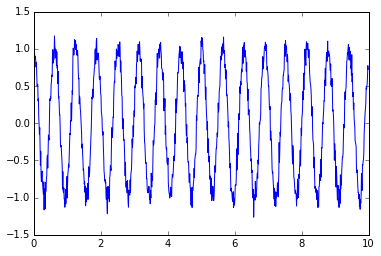

In [261]:
test_data = test_model.simulate_noisy_data(test_tees,true_scaling_parameters,true_system_parameters,GaussianNoiseModel(0.1,0.))
plt.plot(test_tees,test_data)


/home/ni/.virtualenvs/ni/lib/python2.7/site-packages/ipykernel/__main__.py:203: RuntimeWarning: overflow encountered in exp


[(array([ 6.]), 0.34908324647331823),
 (array([ 6.1]), 0.0004279400398971776),
 (array([ 6.2]), 0.00010948615458603455),
 (array([ 6.3]), 0.020915022271230637),
 (array([ 6.4]), 0.56002149203763918),
 (array([ 6.5]), 0.53254504429535487),
 (array([ 6.6]), 0.75051026795602693),
 (array([ 6.7]), 0.015917011000021134),
 (array([ 6.8]), 0.018476981090123079),
 (array([ 6.9]), 1.0308801695136703e-06),
 (array([ 7.]), 0.46960034445735466),
 (array([ 7.1]), 0.33289643522930051),
 (array([ 7.2]), 1.2023444431483679),
 (array([ 7.3]), 0.19255920467397417),
 (array([ 7.4]), 0.081798188639095534),
 (array([ 7.5]), 0.00017997239475194492),
 (array([ 7.6]), 0.72726217476427568),
 (array([ 7.7]), 2.1721193552728622),
 (array([ 7.8]), 2.9895734611749925),
 (array([ 7.9]), 1.0958274082288231),
 (array([ 8.]), 0.10755747897369787),
 (array([ 8.1]), 0.02517326938251252),
 (array([ 8.2]), 0.16537785765146709),
 (array([ 8.3]), 3.604860328166819),
 (array([ 8.4]), 3.8144220393085302),
 (array([ 8.5]), 4.7

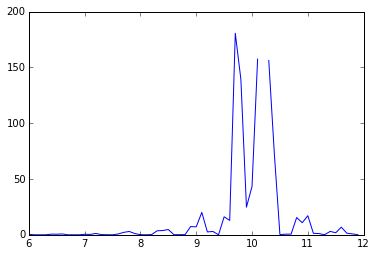

In [263]:
test_system_parameters = np.arange(6.0,12.0,0.1)[:,np.newaxis]

likelihoods = np.log10(np.array([test_model.likelihood(test_tees,x,test_data) for x in test_system_parameters]))
plt.plot(test_system_parameters,likelihoods)
zip(test_system_parameters,likelihoods)

In [257]:
def f(x,w,A,B):
    return A*np.cos(w*x)+B*np.sin(w*x)

popt, pcov = curve_fit(f,test_tees,test_data,p0 = [8,1.0,0.0])

In [258]:
popt

array([ 7.84876394,  0.02359865, -0.09672485])

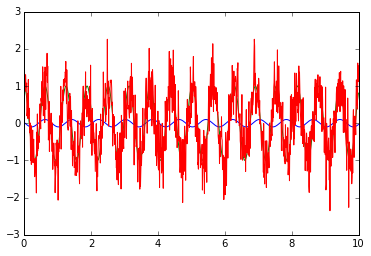

In [259]:
plt.plot(test_tees,f(test_tees,*popt))
plt.plot(test_tees,f(test_tees,10,1.0,0.0))
plt.plot(test_tees,test_data)

In [ ]:
class AbstractDistribution(object):
    __metaclass__ = ABCMeta
    
    @abstractproperty 
    def scaling_parameters(self):
        pass
    
    @abstractproperty
    def noise_parameters(self):
        pass
    
    @abstractproperty
    def system_parameters(self):
        pass
    
    @abstractproperty
    def distribution_type(self):
        """
        eg. Matrix, function or point-like for now
        """
        pass
    
    @abstractproperty
    def distribution_representation(self):
        """
        returns the representation of the distribution. If a matrix return the matrix, if a function return the function, 
        if a point-like return the list of points. 
        """
        pass
    
    @abstractmethod
    def maximum_value(self):
        """
        return the maximal value of the distribution
        """
        pass
    
    @abstractmethod
    def normalize(self):
        """
        Normalize the distribution
        """
        pass
    

In [ ]:
class AbstractParameterEstimator(object):
    __metaclass__ = ABCMeta
    
    @abstractproperty
    def system_model(self):
        pass
    
    @abstractproperty
    def orthogonal_system_model(self):
        pass
    
    @abstractproperty
    def initial_prior(self):
        pass
    
    @abstractproperty 
    def previous_prior(self):
        pass
    
    @abstractproperty 
    def likelihood_distribution(self):
        pass
    
    @abstractmethod 
    def likelihood(self,data,scaling_parameters,system_parameters):
        """
        data should be a Nxm array, where N is the number of data samples, and m is the number of values per sample
        """
        pass
    
    @abstractmethod
    def expected_scaling_parameters(self):
        pass
    
    @abstractmethod 
    def expected_system_parameters(self):
        pass
    
    @abstractmethod
    def expected_noise_parameters(self):
        pass
    
    @abstractmethod
    def add_data(self,data):
        """
        Account for new information (data) and update likelihoods/ distributions
        """
        pass
    
    @abstractmethod
    def simulate_data(self,scaling_parameters,system_parameters,noise_parameters):
        pass
    
    

In [ ]:
def GaussianNoiseParameterEstimator(AbstractParameterEstimator):
    
    def __init__(self,system_model,noise_rms=None):
        self._system_model = system_model
        
    
    @property 
    def system_model(self):
        return self._system_model
    
    

In [ ]:
class OrthonormalizedModel(OrthonormalizableSystemModel):  
    
    
    def __init__(self,parent_model,data):
        self._parent_model = parent_model
        self._data = data 
        
        
        super(OrthonormalizableSystemModel,self).__init__()
        
    @property
    def parent_model(self):
        return self._parent_model
    
    @property
    def data(self):
        return self._data
   
    @property 
    def root_parent_model(self):
        """
        Traverses linked list formed by parent models, 
        to find the root OrthonormalizableSystemModel
        """
        child = self
        while isinstance(child,OrthonormalizedModel):
            parent = self.parent_model
            child = parent
        return child 
        
    def recover_amplitudes(self,orthonormalized_amplitudes):
        pass
    
    def recover_root_amplitudes(self,orthonormalized_amplitudes):
        """
        Traverses linked list formed by parent models, 
        to find the root original amplitudes in terms of 
        the orthonormalized amplitudes
        """
        
        child = self
        while isinstance(child,OrthonormalizedModel):
            orthonormalized_amplitudes = child.recover_amplitudes(orthonormalized_amplitudes)
            parent = self.parent_model
            child = parent
        
        return orthonormalized_amplitudes
        
        